# M54 data 

Four our test with real data, we will use the globular cluster M54. Benefit of this object is that we have a good estimate of the ground truth. A comparison between the (age,metallicity) distributions from MAP estimates (using the PPXF software) and the ground truth is presented in [Boecker et al](https://ui.adsabs.harvard.edu/abs/2020ApJ...896...13B/abstract) (who also kindly provided this data).

The code has been updated to read in this data. Before running this, you will need:
1. `pip install spectres`
2. get the appropriate SSP models. To do this:
   - go to the [MILES site](http://research.iac.es/proyecto/miles/pages/webtools/tune-ssp-models.php)
   - in the 'Input parameters' section, choose 'E-MILES' in the drop down menu under 'SSP Models'
   - leave all other settings as default
   - click 'Submit Query'
   - a new page opens. Follow the link to the 'MILES FTP'
   - this should open a folder with several tarred data files. You want `EMILES_BASTI_BASE_BI_FITS.tar.gz`
   - unzip this into the location `uq4pk/data/EMILES_BASTI_BASE_BI_FITS`. This should contain 8904 files with names like `Ebi3.50Zp0.40T14.0000_iTp0.00_baseFe.fits`

## Look at the data

In [ ]:
cd ../

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
print(m54_data.y.shape)

m54_data.logarithmically_resample(dv=50.)
print(m54_data.y.shape)

(3361,)

Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 

(3800,)


The M54 data consists of a observed spectrum, noise level, and a mask. The regions with `mask==0` should be excluded from the fit as they are contaminated with sky spectra.

Text(0, 0.5, 'Mask [0=exclude]')

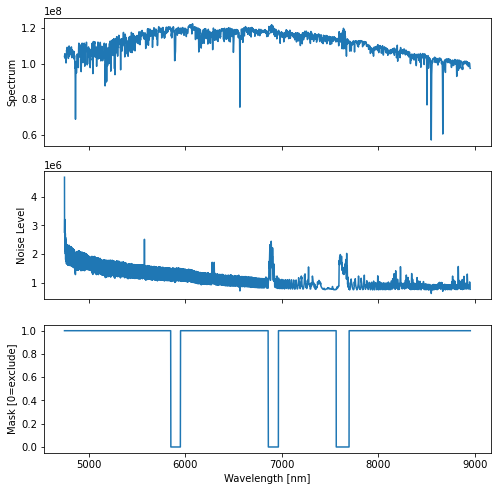

In [2]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax[0].plot(m54_data.lmd, m54_data.y)
ax[1].plot(m54_data.lmd, m54_data.noise_level)
ax[2].plot(m54_data.lmd, m54_data.mask)

ax[2].set_xlabel('Wavelength [nm]')
ax[0].set_ylabel('Spectrum')
ax[1].set_ylabel('Noise Level')
ax[2].set_ylabel('Mask [0=exclude]')

Additionally, we have estimates of age/metallicity distributiuons:

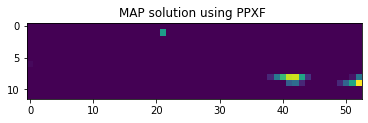

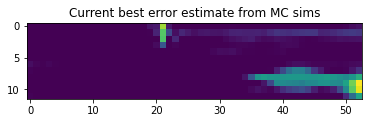

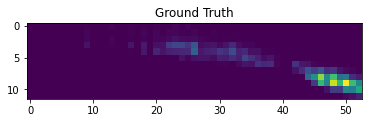

In [3]:
def orient_image(img):
    return np.flipud(img.T)

# MAP solutuon
img = m54_data.ppxf_map_solution
plt.imshow(orient_image(img))
plt.gca().set_title('MAP solution using PPXF ')
plt.show()

# current best error estimate
# 100 MAP solutions from monte carlo resampling of noise
img = np.std(m54_data.mcsims_map_weights, -1)
plt.imshow(orient_image(img))
plt.gca().set_title('Current best error estimate from MC sims')
plt.show()

# ground truth 
img = m54_data.ground_truth
plt.imshow(orient_image(img))
plt.gca().set_title('Ground Truth')
plt.show()

## SSP models

*Note*: the SSP models we need to fit this data are different to those we have been using previously (due to different wavelength ranges). To get the right models, follow the instructions above to get the data-files, which should then be read in as follows,

In [4]:
ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light

## Evaluating the observation operator

In [6]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps,
                        dv=ssps.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


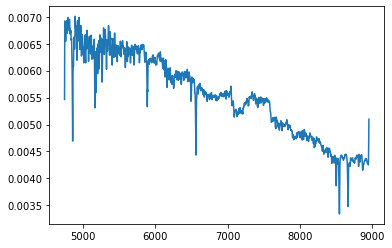

In [7]:
# example input parametrs
f = np.abs(np.random.uniform(size=(12,53)))
Theta_v = [50, 100, 1, 0, 0, 0.3, 0.1]

ybar = G.evaluate(f, Theta_v)

plt.plot(ssps.lmd, ybar, '-')

The jump seen at the start and end of this model spectrum are artifacts of performing a convolution using fourier transforms (which incorrectly assumes that the LOSVD is periodic).

To counter this, we can add the first and last pixels to the data mask,

In [8]:
npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

### Re-creating the ppxf fit

In [9]:
from ppxf import ppxf

In [10]:
templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates, 
    galaxy, 
    noise, 
    velscale,
    start=start,
    degree=8,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask    
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       145        30     0.016    -0.300
chi2/DOF: 1.962; degree = 8; mdegree = 0
method = capfit; Jac calls: 10; Func calls: 56; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  5 / 636


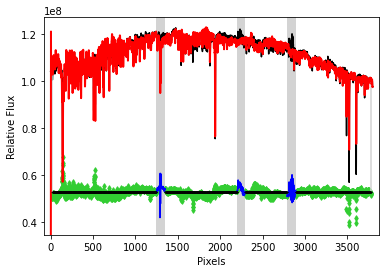

In [11]:
ppxf_fit.plot()

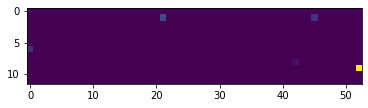

In [12]:
img = np.reshape(ppxf_fit.weights, ssps.par_dims).T
plt.imshow(orient_image(img))

## Different ObservationOperators ?

The PPFX reconstruction, when put through our observation operator, does not reproduce the data. Why?

PPXF models more effects more than our observation operator does, to treat known systematics. One such effect is distortions to the shape of the spectral continuum, caused by inadequacies in data-reduction and/or by the effect of dust-absorption. This can be treated in PPXF by setting the following parameter (from ppxf docs):

```
mdegree:
Degree of the multiplicative Legendre polynomial (with a mean of 1) used to correct the continuum shape during the fit (default: 0). The zero degree multiplicative polynomial is always included in the fit as it corresponds to the weights assigned to the templates. Note that the computation time is longer with multiplicative polynomials than with the same number of additive polynomials.
```

From the Boeker et al paper, they say they make the following choices for `mdegree`:

```
Solely multiplicative polynomials are used to correct for any continuum mismatch between the SSP models and the observed spectrum. Their degree is determined according to $[(\lambda_\mathrm{max}-\lambda_\mathrm{min})/200 Å]$ ,ensuring that spectral features narrower than 200 Å are not influenced by the polynomial
```

*Solely multiplicative* implies that no additive polynomial is used, which requires the `degree=-1` to be set. The precise numberical value of `mdegree` which has been used is unclear from that description, but it > 0. Let's try `mdegree=10`. Redoing the PPXF fit with these two parameters set:

In [13]:
ppxf_fit_mdegree = ppxf.ppxf(
    templates, 
    galaxy, 
    noise, 
    velscale,
    start=start,
    degree=-1,
    mdegree=10,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask    
)

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.008    -0.003
chi2/DOF: 1.143; degree = -1; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 139; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 636


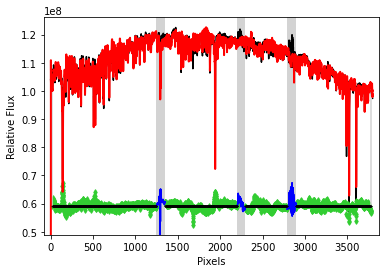

In [14]:
ppxf_fit_mdegree.plot()

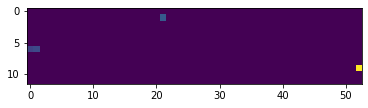

In [15]:
img = np.reshape(ppxf_fit_mdegree.weights, ssps.par_dims).T
plt.imshow(orient_image(img))

We can plot the bestfitting polynomial function which PPXF has found is needed to correct the shape of the spectral continum.

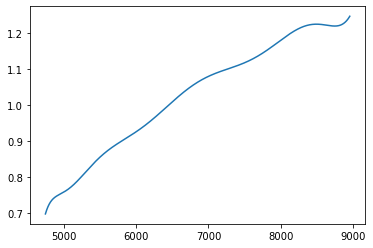

In [17]:
lmd = np.exp(ssps.w[:-1])
plt.plot(lmd, ppxf_fit_mdegree.mpoly)

The `mdegree=10` polynomial coefficients are free parameters which have been optimised by the fit. The best fit values which have been found are,

In [18]:
ppxf_fit_mdegree.mpolyweights

array([ 0.27528962, -0.0209337 , -0.01079055, -0.00259699, -0.00535378,
       -0.00957602, -0.01037294,  0.0041587 ,  0.02603837,  0.0018896 ])

These are weights for Legendre polynomials. The resulting polynomial can be evaluated as,

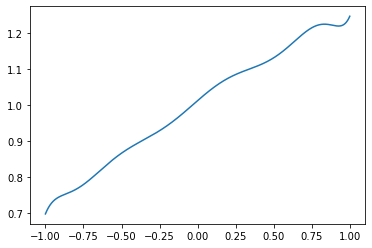

In [19]:
from numpy.polynomial import legendre
x = np.linspace(-1, 1, len(galaxy))
y = legendre.legval(x, np.append(1, ppxf_fit_mdegree.mpolyweights))
plt.plot(x, y)

### How to proceed?

The aim of our initial exercise was to demonstrate an improved method for UQ for our problem. We had hoped that tests using idealised mock data (unaffected by real data systematics) would be enough to demonstrate this.

Real data however, unfortuneately suffers from the continuum distortion systematic. So to proceed with real data, our options are either:
1. update our observation operator to handle continuum distortion. This could be using the same approach as PPXF, i.e. multiplication by a legendre polynomial. It could, however, suffice to have just use a linear function, which would caputure the majority of the effect and only intoduce one new parameter to the fit.
2. *NOT* update our observation operator, but instead we could *correct* the templates by the continuum distortion found by PPXF, i.e.

For now we will go for option 2.

To correct the templates using the continuum distortion found by PPXF, do the following:

In [20]:
continuum_distorition = ppxf_fit_mdegree.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw *= (ssps_corrected.Xw.T * continuum_distorition).T

Now to modify the observation operator we relpace the ssps by these "corrected" versions,

In [21]:
G = ObservationOperator(ssps=ssps_corrected,
                        dv=ssps_corrected.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


Testing the new observation operator
-----------------------------------

Let us check whether the improved observation operator leads to a better data-fit.

We don't fit $\theta_v$, but set it equal to the PPXF-best fit.

In [22]:
theta_v = np.array([146, 3, 1., 0., 0., -0.008, -0.003])

In [56]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]
G_old = ObservationOperator(ssps=ssps, dv=ssps.dv, do_log_resample=False)
f_ppxf = np.reshape(ppxf_fit_mdegree.weights, ssps.par_dims).T
f_ppxf = orient_image(f_ppxf)

y_hat_old = G_old.evaluate(f_ppxf, theta_v)[mask]
y_hat_new = G.evaluate(f_ppxf, theta_v)[mask]
data_fit_old = np.linalg.norm((y - y_hat_old) / y_sd)
data_fit_new = np.linalg.norm((y - y_hat_new) / y_sd)

print(f"Data fit without correction: {data_fit_old}.")
print(f"Data fit with correction: {data_fit_new}.")

Distribution functions should have shape (12, 53)
Data fit without correction: 6035.450427394506.
Data fit with correction: 6326.314446195051.


So, the corrected observation operator leads to a poorer data fit of the PPXF estimate?
What's up with that?

Let us compare with our MAP estimate.
For this, we first normalize our data. As a baseline, I am using the PPXF MAP solution
from the M54 data:

In [57]:
f_ppxf = orient_image(m54_data.ppxf_map_solution)

f_ppxf_norm = f_ppxf / np.sum(f_ppxf)
y_ref = G_old.evaluate(f_ppxf_norm, theta_v)
# compute a scaling factor such that ||y_ref|| = ||y||
s = np.linalg.norm(y_ref) / np.linalg.norm(y)
# rescale data and noise
y_norm = y.copy()
y_norm *= s
y_sd_norm = y_sd.copy()
y_sd_norm *= s


Next, we fit our model:

In [58]:
from uq4pk_fit.inference import StatModel, ForwardOperator
from uq4pk_fit.visualization import plot_distribution_function

# Initialize ForwardOperator object
forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps, dv=ssps.dv, do_log_resample=False)
# Fit the model
model = StatModel(y=y_norm, y_sd=y_sd_norm, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.normalize()
model.beta1 *= 0.1
fitted_model = model.fit()

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 407.3284177083718
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    8.130628745339402    |  2.4313601277872588e-14 |    0.2694412903970169   |           1.0           |    1.2528443336486816   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    8.130628745339399    |  3.031

Let us plot the MAP estimate and compare it to the PPXF fit.

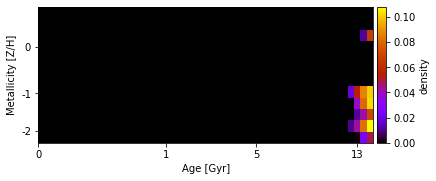

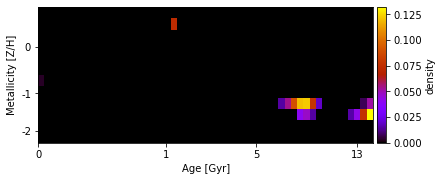

In [59]:
%matplotlib inline
f_map = fitted_model.f_map
plot_distribution_function(image=f_map, ssps=ssps, show=True)
plot_distribution_function(image=f_ppxf_norm, ssps=ssps)

To the best of my judgement, the PPXF fit looks more similar to the ground truth:

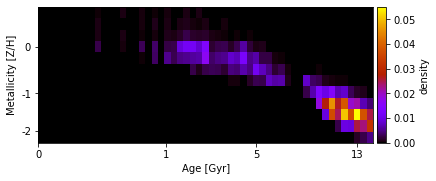

In [60]:
f_gt = m54_data.ground_truth
f_gt = orient_image(f_gt)
f_gt_normalized = f_gt / np.sum(f_gt)
plot_distribution_function(image=f_gt_normalized, ssps=ssps)

But do the numbers agree? Let's compute the data fit with respect to the old, uncorrected
observation operator.

In [61]:
# Compute data fit
y_hat_map = G_old.evaluate(f_map, theta_v)[mask]
y_hat_ppxf = G_old.evaluate(f_ppxf_norm, theta_v)[mask]
data_fit_map = np.linalg.norm((y_norm - y_hat_map) / y_sd_norm)
data_fit_ppxf = np.linalg.norm((y_norm - y_hat_ppxf) / y_sd_norm)
print(f"Data fit of MAP: {data_fit_map}")
print(f"Data fit of PPXF: {data_fit_ppxf}")

Data fit of MAP: 236.21674887822317
Data fit of PPXF: 460.59693393747085


Our MAP estimate matches the data better than the PPXF fit. Interesting.
As a further measure, let us look at the error relative to the M54 ground truth:

In [62]:
def reconstruction_error(f):
    error = np.linalg.norm(f - f_gt_normalized)
    relative_error = error / np.linalg.norm(f_gt_normalized)
    return relative_error

e_map = reconstruction_error(f_map)
e_ppxf = reconstruction_error(f_ppxf_norm)
print(f"MAP reconstruction error: {e_map}")
print(f"PPXF reconstruction error: {e_ppxf}")


MAP reconstruction error: 1.7729818442801195
PPXF reconstruction error: 1.9687376006498538


So the MAP fit is slightly closer to the ground truth than the PPXF fit in the $l^2$-norm. But both
errors are so large (177% and 197%) that this does not really mean much.
In any case, the $l^2$ error is a mediocre error measures for images. Instead, let us evaluate the [structural
similarity index](https://en.wikipedia.org/wiki/Structural_similarity):

In [63]:
from uq4pk_fit.inference import ssim

ssim_map = ssim(image=f_map, reference=f_gt_normalized)
ssim_ppxf = ssim(image=f_ppxf, reference=f_gt_normalized)
print(f"SSIM of MAP: {ssim_map}")
print(f"SSIM of PPXF: {ssim_ppxf}")


SSIM of MAP: 0.36584044039099634
SSIM of PPXF: 0.3591305657382599


Note that for the structural similarity index, a value of $0$ means no similarity,
while a value of $1$ means identity. Hence, our MAP estimate has a slightly better SSIM.

Anyway, what happens if we reperform this test using the corrected observation operator?
First, we have to update the normalization?

In [64]:
f_ppxf = orient_image(m54_data.ppxf_map_solution)

f_ppxf_norm = f_ppxf / np.sum(f_ppxf)
y_ref = G.evaluate(f_ppxf_norm, theta_v)
# compute a scaling factor such that ||y_ref|| = ||y||
s = np.linalg.norm(y_ref) / np.linalg.norm(y)
# rescale data and noise
y_norm = y.copy()
y_norm *= s
y_sd_norm = y_sd.copy()
y_sd_norm *= s


Now, let's fit:

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 64.19835488400224
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    17.022966675532924   |  8.879054105175597e-15  |   0.21385258637813329   |           1.0           |    1.2027125358581543   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    17.022966675532885   |  6.437

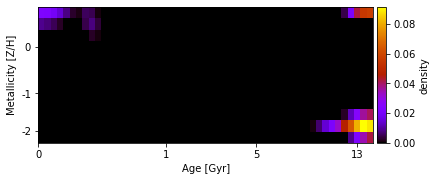

In [65]:
forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_norm, y_sd=y_sd_norm, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.normalize()
model.f_start = f_gt_normalized.flatten()
fitted_model = model.fit()
f_map_corrected = fitted_model.f_map
plot_distribution_function(image=f_map_corrected, ssps=ssps_corrected, show=True)

Interesting. Let's reevaluate the data fit:

In [66]:
# Compute data fit
y_hat_map = G.evaluate(f_map_corrected, theta_v)[mask]
y_hat_ppxf = G.evaluate(f_ppxf_norm, theta_v)[mask]
data_fit_map = np.linalg.norm((y_norm - y_hat_map) / y_sd_norm)
data_fit_ppxf = np.linalg.norm((y_norm - y_hat_ppxf) / y_sd_norm)
print(f"Data fit of MAP: {data_fit_map}")
print(f"Data fit of PPXF: {data_fit_ppxf}")

Data fit of MAP: 339.56417784462076
Data fit of PPXF: 652.4784204336424


Also, compare to the ground truth:

In [67]:
ssim_map_corrected = ssim(image=f_map_corrected, reference=f_gt_normalized)
print(f"SSIM of MAP: {ssim_map}")
print(f"SSIM of PPXF: {ssim_ppxf}")
print(f"SSIM of MAP, corrected: {ssim_map_corrected}")

SSIM of MAP: 0.36584044039099634
SSIM of PPXF: 0.3591305657382599
SSIM of MAP, corrected: 0.3217824094833696


So, it seems that the corrected observation operator affects the quality of our MAP estimate
*negatively*.